<a href="https://colab.research.google.com/github/bechosen-spec/Women-Football-Result-Prediction/blob/main/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tabulate
!pip install category_encoders
!pip install catboost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from tabulate import tabulate
import category_encoders
import time
%matplotlib inline


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HAMOYE INTERNSHIP/Captone Project 1/cleaned_results.csv')

In [5]:
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1969-11-01,Italy,France,1,0,Euro,Novara,Italy,False
1,1969-11-01,Denmark,England,4,3,Euro,Aosta,Italy,True
2,1969-11-02,England,France,2,0,Euro,Turin,Italy,True
3,1969-11-02,Italy,Denmark,3,1,Euro,Turin,Italy,False
4,1975-08-25,Thailand,Australia,3,2,AFC Championship,Hong Kong,Hong Kong,True


In [6]:
df.shape

(4884, 9)

In [7]:
df.corr()

<ipython-input-7-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,home_score,away_score,neutral
home_score,1.000000,-0.333133,0.003656
away_score,-0.333133,1.000000,-0.045386
neutral,0.003656,-0.045386,1.000000


In [8]:
df.count()

date          4884
home_team     4884
away_team     4884
home_score    4884
away_score    4884
tournament    4884
city          4884
country       4884
neutral       4884
dtype: int64

In [9]:
df.dtypes

date          object
home_team     object
away_team     object
home_score     int64
away_score     int64
tournament    object
city          object
country       object
neutral         bool
dtype: object

<ipython-input-10-98117ad09575>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.drop(['date'], axis = 1).corr(), annot=True)


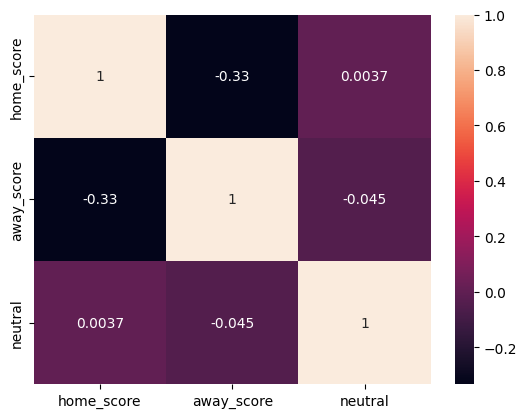

In [10]:
sns.heatmap(df.drop(['date'], axis = 1).corr(), annot=True)
plt.show()

## MY MODELLING

In [11]:
df["Year"] = pd.to_datetime(df['date']).dt.year
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Year
0,1969-11-01,Italy,France,1,0,Euro,Novara,Italy,False,1969
1,1969-11-01,Denmark,England,4,3,Euro,Aosta,Italy,True,1969
2,1969-11-02,England,France,2,0,Euro,Turin,Italy,True,1969
3,1969-11-02,Italy,Denmark,3,1,Euro,Turin,Italy,False,1969
4,1975-08-25,Thailand,Australia,3,2,AFC Championship,Hong Kong,Hong Kong,True,1975


In [12]:
features_df = df.drop(columns=["home_score", "away_score", "date"])
y_home = df["home_score"]
y_away = df["away_score"]

In [13]:
### Frequency Encoding
features_df_copy = features_df.copy()
columns_list = features_df.columns

#encode all columns
for col in columns_list:
  #encoder
  encoder = category_encoders.CountEncoder(cols = col, normalize=True)

  ##fit and transform
  features_df[col] = encoder.fit_transform(features_df[col])

features_df.head()

,home_team,away_team,tournament,city,country,neutral,Year
0,0.022318,0.021908,0.004095,0.000205,0.016994,0.556511,0.000819
1,0.024570,0.020680,0.004095,0.000205,0.016994,0.443489,0.000819
2,0.022113,0.021908,0.004095,0.000614,0.016994,0.443489,0.000819
3,0.022318,0.030917,0.004095,0.000614,0.016994,0.556511,0.000819
4,0.010442,0.013309,0.054873,0.011671,0.011671,0.443489,0.002048


In [14]:
models = {
    'LinearRegression':LinearRegression(),
    'Ridge':Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'SGDRegressor': SGDRegressor(),
    'DecissionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42)
}

In [15]:
def models_eval(models, X, y):
    #helper lists
    mse_train, mse_val, mse_test, r2_train, r2_test, model_name = [], [], [],[], [], []

    #split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #run models in loops
    for name, model in models.items():
        model_name.append(name) #Saving the name of model
        model.fit(X_train ,y_train) #Fitting model on training set

        ## ON TRAIN
        y_pred_train = model.predict(X_train) #Making prediction on already seen data
        mse_train.append(mean_squared_error(y_train, y_pred_train)) #Evaluation on training set
        r2score_train = r2_score(y_train, y_pred_train) #Computing R2_score train
        r2_train.append(r2score_train)

        # ON CrossValidation...
        val_scores = cross_val_score(model, X_train, y_train,scoring="neg_mean_squared_error", cv=5)
        mse_val.append((-val_scores).mean())

        #ON Test
        y_pred_test = model.predict(X_test)
        mse_test.append(mean_squared_error(y_test, y_pred_test))
        r2score_test = r2_score(y_test, y_pred_test)
        r2_test.append(r2score_test)

    # Create DataFrame for the models and their RMSE values
    eval_df = pd.DataFrame({'MSE_Train': mse_train, 'MSE_Val': mse_val, 'MSE_Test':mse_test,'R2_Train':r2_train, 'R2_Test':r2_test}, index=model_name)
    return eval_df

In [16]:
eval_df_home = models_eval(models, features_df, y_home)

In [17]:
eval_df_home

,MSE_Train,MSE_Val,MSE_Test,R2_Train,R2_Test
LinearRegression,5.936910,5.948246,5.567113,0.211767,0.237397
Ridge,6.924426,7.013199,6.623449,0.080656,0.092697
Lasso,7.531923,7.533962,7.304317,0.000000,-0.000571
ElasticNet,7.531923,7.533962,7.304317,0.000000,-0.000571
SGDRegressor,7.474256,7.486614,7.246805,0.007656,0.007307
DecissionTree,0.074652,8.508119,7.726459,0.990089,-0.058397
RandomForest,0.651664,4.494428,4.043881,0.913480,0.446055


In [18]:
eval_df_away = models_eval(models, features_df, y_away)

In [19]:
eval_df_away

,MSE_Train,MSE_Val,MSE_Test,R2_Train,R2_Test
LinearRegression,3.341061,3.351610,3.222430,0.148134,0.152738
Ridge,3.671024,3.705761,3.534219,0.064004,0.070760
Lasso,3.922050,3.924410,3.804247,0.000000,-0.000237
ElasticNet,3.922050,3.924410,3.804247,0.000000,-0.000237
SGDRegressor,3.909234,3.904587,3.775370,0.003268,0.007355
DecissionTree,0.021201,5.225247,5.630246,0.994594,-0.480341
RandomForest,0.399135,2.840798,2.886472,0.898233,0.241070


## HYPERPARAMETER TUNING

### Home Scores

In [20]:
#Hypertuning the parameters of the Random forest regressor for home score
X_train, X_test, y_train, y_test = train_test_split(features_df, y_home, test_size=0.2, random_state=42)

In [22]:
# Before tuning
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#mse
mse = mean_squared_error(y_test, y_pred)
print("Mean-squared error:", mse)

#r2 score
r2 = r2_score(y_test, y_pred)
print("R-squared score:", r2)

Mean-squared error: 4.04388146928473
R-squared score: 0.44605494687083147


In [23]:
#Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}
scoring = {
    'MSE': make_scorer(mean_squared_error),
    'R2': make_scorer(r2_score)}

#Grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, refit='MSE', cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

#loss functions
best_mse = grid_search.best_score_
best_r2 = grid_search.cv_results_['mean_test_R2'][grid_search.best_index_]
best_model = RandomForestRegressor(**best_params)
best_model.fit(X_train, y_train)


y_pred = best_model.predict(X_test) #predictions
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best parameters:", best_params)
print("Best MSE:", best_mse)
print("Best R2:", best_r2)
print("MSE on test set:", mse)
print("R2 on test set:", r2)

Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best MSE: 4.526806521611325
Best R2: 0.39976987276085557
MSE on test set: 4.095752015499591
R2 on test set: 0.4389495376996986


In [24]:
#Use the best parameters
model = RandomForestRegressor(n_estimators=100,max_depth=5, min_samples_split=10, min_samples_leaf=1, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#errors functions
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean-squared error:", mse)
print("R-squared score:", r2)

Mean-squared error: 4.0753167965730155
R-squared score: 0.44174882559178175


### Away Scores

In [25]:
X_train, X_test, y_train, y_test = train_test_split(features_df, y_away, test_size=0.2, random_state=42)

In [26]:
#Before hyperparameter tuning
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean-squared error:", mse)

r2 = r2_score(y_test, y_pred)
print("R-squared score:", r2)

Mean-squared error: 2.8864719026174868
R-squared score: 0.24106995899253936


In [27]:
#Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}
scoring = {
    'MSE': make_scorer(mean_squared_error),
    'R2': make_scorer(r2_score)}
print(time.time())
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, refit='MSE', cv=5)
grid_search.fit(X_train, y_train)
print(time.time())

best_params = grid_search.best_params_
best_mse = grid_search.best_score_
best_r2 = grid_search.cv_results_['mean_test_R2'][grid_search.best_index_]
best_model = RandomForestRegressor(**best_params)


best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best parameters:", best_params)
print("Best MSE:", best_mse)
print("Best R2:", best_r2)
print("MSE on test set:", mse)
print("R2 on test set:", r2)

1687160109.5673862
1687160699.3891575
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best MSE: 2.8407984736759015
Best R2: 0.27435718364502354
MSE on test set: 2.870006882287511
R2 on test set: 0.2453990496526237


In [28]:
model = RandomForestRegressor(n_estimators=100,max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#loss functions
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean-squared error:", mse)
print("R-squared score:", r2)

Mean-squared error: 2.8864719026174868
R-squared score: 0.24106995899253936
